Étape 1 : Installation et imports

In [32]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Dict, List, Tuple
import time
import glob
import sys

print("✅ Toutes les librairies sont chargées !")
print(f"📍 Répertoire de travail actuel : {os.getcwd()}")

✅ Toutes les librairies sont chargées !
📍 Répertoire de travail actuel : c:\Users\msi\Downloads\Computer-vision-project\Computer-vision-project\notebooks


 Étape 2 : Configuration du dataset avec tes chemins

In [33]:
from pathlib import Path

# 📁 Chemin du dataset (depuis notebooks/)
DATASET_PATH = Path('../dataset')

# Mapping des noms de dossiers français → anglais
STYLE_MAPPING = {
    'boheme': 'bohemian',
    'royal': 'royal',
    'minimaliste': 'minimalist',
    'rustique': 'rustic',
    'vintage': 'vintage',
    'moderne': 'modern',
    'industriel': 'industrial'
}

# Ordre des styles pour l'affichage
STYLE_ORDER = [
    'bohemian',
    'royal',
    'minimalist',
    'rustic',
    'vintage',
    'modern',
    'industrial'
]

# 📂 Configuration des chemins
BASE_DIR = DATASET_PATH.parent.absolute()
DATASET_DIR = DATASET_PATH.absolute()

# 🎨 Styles (noms EXACTS des dossiers dans dataset/)
STYLES = [
    'boheme',
    'industriel',
    'minimaliste',
    'moderne',
    'royal',
    'rustique',
    'vintage'
]

# ✅ CORRECTION — définition des dossiers attendus par analyze_dataset
TRAIN_DIR = DATASET_DIR
TEST_DIR = DATASET_DIR

print("=" * 70)
print("🔧 CONFIGURATION DU DATASET")
print("=" * 70)
print(f"\n📂 Répertoire de base : {BASE_DIR}")
print(f"📂 Dataset            : {DATASET_DIR}")
print(f"📂 Dataset existe     : {'✅' if DATASET_DIR.exists() else '❌'}")
print(f"\n🎨 Styles configurés : {len(STYLES)}")
print(f"   Dossiers (FR) : {', '.join(STYLES)}")
print("=" * 70)


🔧 CONFIGURATION DU DATASET

📂 Répertoire de base : c:\Users\msi\Downloads\Computer-vision-project\Computer-vision-project\notebooks\..
📂 Dataset            : c:\Users\msi\Downloads\Computer-vision-project\Computer-vision-project\notebooks\..\dataset
📂 Dataset existe     : ✅

🎨 Styles configurés : 7
   Dossiers (FR) : boheme, industriel, minimaliste, moderne, royal, rustique, vintage


Étape 3 : Vérification et analyse du dataset

In [34]:
def analyze_dataset(base_path, split_name="train"):
    """Analyse le contenu du dataset"""
    
    if not base_path.exists():
        print(f"❌ Chemin introuvable : {base_path}")
        return False, {}
    
    print(f"\n📊 ANALYSE DU DATASET - {split_name.upper()}")
    print("=" * 70)
    
    total_images = 0
    dataset_info = {}
    
    for style in STYLES:
        style_path = base_path / style
        
        if not style_path.exists():
            print(f"   ⚠️  {style:15s} : Dossier introuvable")
            dataset_info[style] = {'count': 0, 'path': style_path, 'images': []}
            continue
        
        # Compter les images (tous formats)
        images = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            images.extend(glob.glob(str(style_path / ext)))
        
        count = len(images)
        total_images += count
        dataset_info[style] = {
            'count': count,
            'path': style_path,
            'images': images[:10]  # Garder 10 exemples
        }
        
        print(f"   {'✅' if count > 0 else '❌'} {style:15s} : {count:6,d} images")
    
    print(f"\n   {'TOTAL':15s} : {total_images:6,d} images")
    print("=" * 70)
    
    if total_images == 0:
        print("\n❌ ERREUR : Aucune image trouvée !")
        print("\n💡 Vérifications à faire :")
        print("   1. Les chemins sont-ils corrects ?")
        print("   2. Les images sont-elles dans les sous-dossiers ?")
        print("   3. Les formats sont-ils .jpg, .jpeg ou .png ?")
        return False, {}
    else:
        print(f"\n✅ Dataset prêt avec {total_images:,} images !")
        return True, dataset_info


# Analyser le dataset d'entraînement
TRAIN_READY, TRAIN_INFO = analyze_dataset(TRAIN_DIR, "train")

# Analyser le dataset de test
TEST_READY, TEST_INFO = analyze_dataset(TEST_DIR, "test")

# Déterminer quel dataset utiliser pour les tests
if TRAIN_READY:
    WORKING_DIR = TRAIN_DIR
    WORKING_INFO = TRAIN_INFO
    print(f"\n🎯 Utilisation du dataset d'ENTRAÎNEMENT pour les tests")
elif TEST_READY:
    WORKING_DIR = TEST_DIR
    WORKING_INFO = TEST_INFO
    print(f"\n🎯 Utilisation du dataset de TEST pour les tests")
else:
    WORKING_DIR = None
    WORKING_INFO = {}
    print(f"\n❌ Aucun dataset disponible")

DATASET_READY = TRAIN_READY or TEST_READY


📊 ANALYSE DU DATASET - TRAIN
   ✅ boheme          : 13,152 images
   ✅ industriel      :  8,370 images
   ✅ minimaliste     : 10,068 images
   ✅ moderne         : 12,578 images
   ✅ royal           : 12,326 images
   ✅ rustique        : 13,192 images
   ✅ vintage         : 12,978 images

   TOTAL           : 82,664 images

✅ Dataset prêt avec 82,664 images !

📊 ANALYSE DU DATASET - TEST
   ✅ boheme          : 13,152 images
   ✅ industriel      :  8,370 images
   ✅ minimaliste     : 10,068 images
   ✅ moderne         : 12,578 images
   ✅ royal           : 12,326 images
   ✅ rustique        : 13,192 images
   ✅ vintage         : 12,978 images

   TOTAL           : 82,664 images

✅ Dataset prêt avec 82,664 images !

🎯 Utilisation du dataset d'ENTRAÎNEMENT pour les tests


 Étape 4 : Fonctions d'extraction de couleurs

In [35]:
def rgb_to_hex(rgb: Tuple[int, int, int]) -> str:
    """Convertit une couleur RGB en format hexadécimal"""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))


def extract_dominant_colors_fast(image_path: str, num_colors: int = 5, resize_dim: int = 100) -> dict:
    """
    Version optimisée pour vitesse de l'extraction de couleurs dominantes.
    
    Args:
        image_path: Chemin vers l'image
        num_colors: Nombre de couleurs à extraire
        resize_dim: Taille de redimensionnement pour accélérer (ex: 100 px)
        
    Returns:
        Dictionnaire avec colors, percentages, rgb_colors, success, original_image
    """
    try:
        if not os.path.exists(image_path):
            return {'success': False, 'error': f"Fichier introuvable : {image_path}"}
        
        image = cv2.imread(image_path)
        if image is None:
            return {'success': False, 'error': f"Impossible de charger : {image_path}"}
        
        # BGR → RGB et redimensionnement
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (resize_dim, resize_dim), interpolation=cv2.INTER_AREA)
        
        pixels = image.reshape(-1, 3).astype(np.float32)
        
        # KMeans plus rapide
        kmeans = KMeans(
            n_clusters=num_colors,
            random_state=42,
            n_init=5,
            max_iter=200
        )
        kmeans.fit(pixels)
        
        colors_rgb = kmeans.cluster_centers_.astype(int)
        labels = kmeans.labels_
        total_pixels = len(labels)
        label_counts = Counter(labels)
        
        sorted_data = []
        for i in range(num_colors):
            count = label_counts[i]
            percentage = (count / total_pixels) * 100
            rgb = tuple(colors_rgb[i])
            hex_color = rgb_to_hex(rgb)
            sorted_data.append({'rgb': rgb, 'hex': hex_color, 'percentage': percentage})
        
        sorted_data.sort(key=lambda x: x['percentage'], reverse=True)
        
        return {
            'success': True,
            'colors': [item['hex'] for item in sorted_data],
            'percentages': [round(item['percentage'], 2) for item in sorted_data],
            'rgb_colors': [item['rgb'] for item in sorted_data],
            'image_path': image_path,
            'original_image': image
        }
        
    except Exception as e:
        return {'success': False, 'error': f"Erreur : {str(e)}"}


Étape 5 : Fonction de visualisation

In [36]:
def visualize_extraction(result: Dict, figsize=(14, 4)):
    """
    Visualise l'image originale et sa palette de couleurs dominantes
    
    Args:
        result: Dictionnaire retourné par extract_dominant_colors()
        figsize: Taille de la figure matplotlib
    """
    if not result['success']:
        print(f"❌ Erreur : {result['error']}")
        return
    
    # Créer la figure avec 2 sous-graphiques
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Afficher l'image originale
    axes[0].imshow(result['original_image'])
    axes[0].axis('off')
    axes[0].set_title(f"Image : {Path(result['image_path']).name}", 
                     fontsize=11, fontweight='bold')
    
    # Créer la palette de couleurs (barre horizontale)
    palette = np.zeros((100, 500, 3), dtype=np.uint8)
    x_start = 0
    
    for rgb, percentage in zip(result['rgb_colors'], result['percentages']):
        # Calculer la largeur de chaque couleur selon son pourcentage
        x_end = x_start + int(500 * percentage / 100)
        palette[:, x_start:x_end] = rgb
        x_start = x_end
    
    # Afficher la palette
    axes[1].imshow(palette)
    axes[1].axis('off')
    axes[1].set_title("Palette de couleurs dominantes", 
                     fontsize=11, fontweight='bold')
    
    # Afficher les détails des couleurs
    info_text = "   ".join([f"{color} ({pct}%)" 
                            for color, pct in zip(result['colors'], result['percentages'])])
    fig.text(0.5, 0.02, info_text, ha='center', fontsize=9, family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # Affichage textuel détaillé
    print("🎨 Palette extraite :")
    for i, (color, pct, rgb) in enumerate(zip(
        result['colors'], result['percentages'], result['rgb_colors']
    ), 1):
        print(f"   {i}. {color}  |  RGB{rgb}  |  {pct:5.2f}%")
    print()


print("✅ Fonction de visualisation définie !")


✅ Fonction de visualisation définie !


Étape 6 : TEST sur une image de ton dataset

🧪 TEST D'EXTRACTION SUR UNE IMAGE
📂 Style : boheme
📸 Image : 16026.jpg



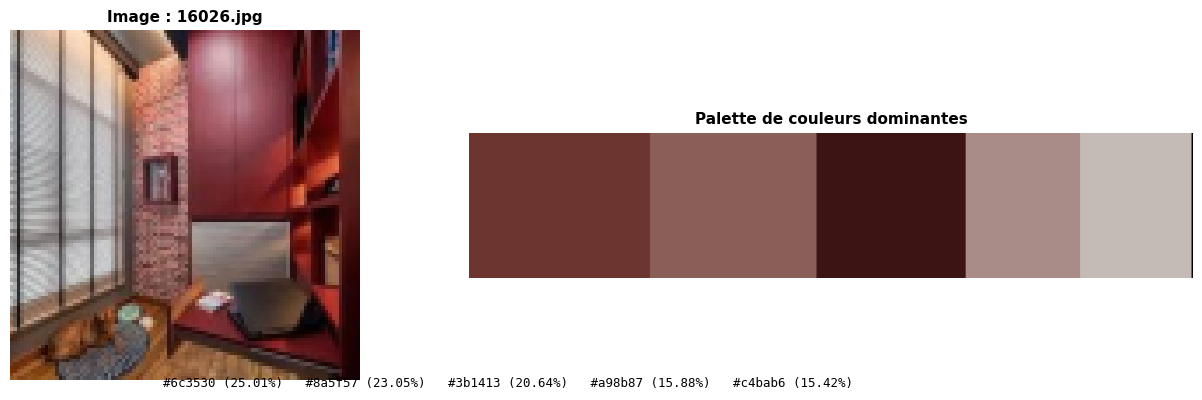

🎨 Palette extraite :
   1. #6c3530  |  RGB(np.int64(108), np.int64(53), np.int64(48))  |  25.01%
   2. #8a5f57  |  RGB(np.int64(138), np.int64(95), np.int64(87))  |  23.05%
   3. #3b1413  |  RGB(np.int64(59), np.int64(20), np.int64(19))  |  20.64%
   4. #a98b87  |  RGB(np.int64(169), np.int64(139), np.int64(135))  |  15.88%
   5. #c4bab6  |  RGB(np.int64(196), np.int64(186), np.int64(182))  |  15.42%



In [37]:
if DATASET_READY and WORKING_INFO:
    print("🧪 TEST D'EXTRACTION SUR UNE IMAGE")
    print("=" * 70)
    
    # Trouver le premier style avec des images
    test_style = None
    test_image = None
    
    for style in STYLES:
        if WORKING_INFO[style]['count'] > 0:
            test_style = style
            test_image = WORKING_INFO[style]['images'][0]
            break
    
    if test_image:
        print(f"📂 Style : {test_style}")
        print(f"📸 Image : {Path(test_image).name}\n")
        
        # Extraire les couleurs
        result = extract_dominant_colors_fast(test_image, num_colors=5)
        
        # Visualiser
        if result['success']:
            visualize_extraction(result)
        else:
            print(f"❌ {result['error']}")
    else:
        print("❌ Aucune image disponible pour le test")
else:
    print("⚠️  Dataset non configuré ou vide")


Étape 7 : Analyse de plusieurs images d'un style

🎨 ANALYSE DE 3 IMAGES - STYLE : BOHEME

📸 Image 1/3


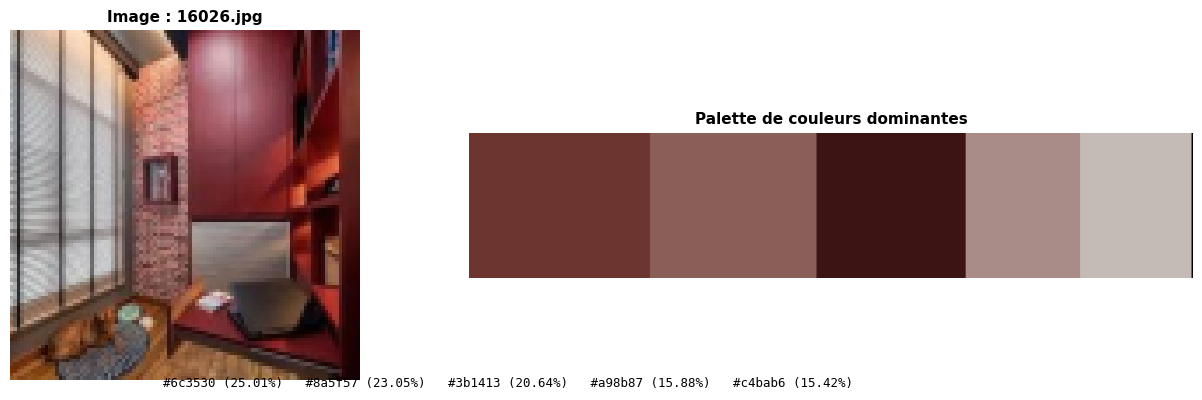

🎨 Palette extraite :
   1. #6c3530  |  RGB(np.int64(108), np.int64(53), np.int64(48))  |  25.01%
   2. #8a5f57  |  RGB(np.int64(138), np.int64(95), np.int64(87))  |  23.05%
   3. #3b1413  |  RGB(np.int64(59), np.int64(20), np.int64(19))  |  20.64%
   4. #a98b87  |  RGB(np.int64(169), np.int64(139), np.int64(135))  |  15.88%
   5. #c4bab6  |  RGB(np.int64(196), np.int64(186), np.int64(182))  |  15.42%

----------------------------------------------------------------------

📸 Image 2/3


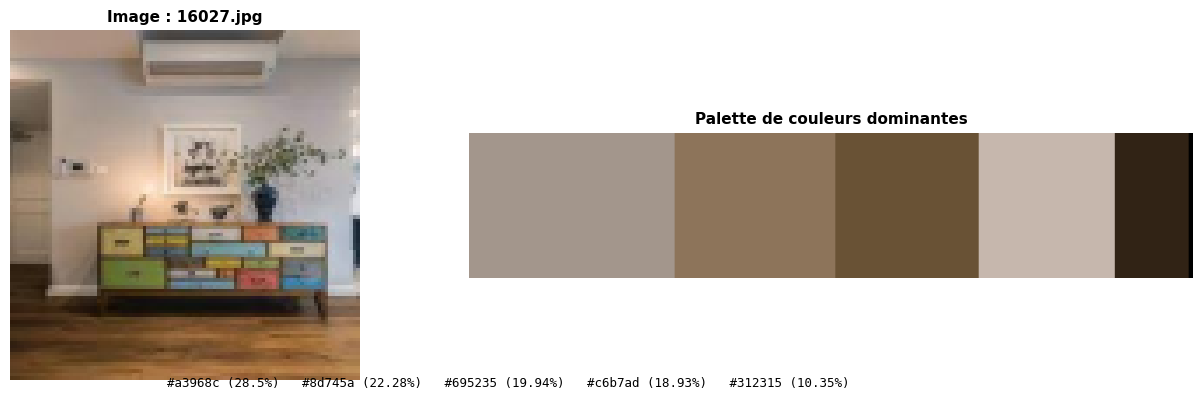

🎨 Palette extraite :
   1. #a3968c  |  RGB(np.int64(163), np.int64(150), np.int64(140))  |  28.50%
   2. #8d745a  |  RGB(np.int64(141), np.int64(116), np.int64(90))  |  22.28%
   3. #695235  |  RGB(np.int64(105), np.int64(82), np.int64(53))  |  19.94%
   4. #c6b7ad  |  RGB(np.int64(198), np.int64(183), np.int64(173))  |  18.93%
   5. #312315  |  RGB(np.int64(49), np.int64(35), np.int64(21))  |  10.35%

----------------------------------------------------------------------

📸 Image 3/3


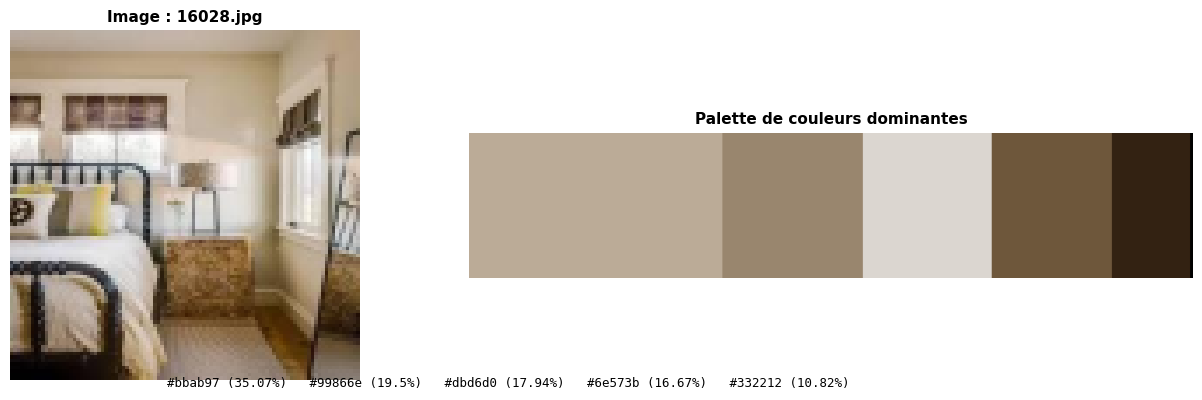

🎨 Palette extraite :
   1. #bbab97  |  RGB(np.int64(187), np.int64(171), np.int64(151))  |  35.07%
   2. #99866e  |  RGB(np.int64(153), np.int64(134), np.int64(110))  |  19.50%
   3. #dbd6d0  |  RGB(np.int64(219), np.int64(214), np.int64(208))  |  17.94%
   4. #6e573b  |  RGB(np.int64(110), np.int64(87), np.int64(59))  |  16.67%
   5. #332212  |  RGB(np.int64(51), np.int64(34), np.int64(18))  |  10.82%

----------------------------------------------------------------------



In [38]:
def analyze_style_samples(style_name: str, num_samples: int = 3):
    """
    Analyse plusieurs images d'un style spécifique
    
    Args:
        style_name: Nom du style (ex: 'bohemian', 'royal')
        num_samples: Nombre d'images à analyser
    """
    if not DATASET_READY:
        print("⚠️  Dataset non configuré")
        return
    
    if style_name not in STYLES:
        print(f"❌ Style '{style_name}' introuvable")
        print(f"   Styles disponibles : {', '.join(STYLES)}")
        return
    
    if WORKING_INFO[style_name]['count'] == 0:
        print(f"❌ Aucune image dans le style '{style_name}'")
        return
    
    # Récupérer les images
    images = WORKING_INFO[style_name]['images'][:num_samples]
    
    print("=" * 70)
    print(f"🎨 ANALYSE DE {len(images)} IMAGES - STYLE : {style_name.upper()}")
    print("=" * 70)
    print()
    
    for i, img_path in enumerate(images, 1):
        print(f"📸 Image {i}/{len(images)}")
        result = extract_dominant_colors_fast(img_path)
        
        if result['success']:
            visualize_extraction(result)
        else:
            print(f"   ❌ {result['error']}")
        
        print("-" * 70)
        print()


# Tester sur 3 images du premier style disponible
if DATASET_READY:
    # Trouver le premier style avec des images
    for style in STYLES:
        if WORKING_INFO[style]['count'] > 0:
            analyze_style_samples(style, num_samples=3)
            break



Étape 8 : Comparaison de TOUS les styles

🌈 COMPARAISON DES STYLES DU DATASET


📌 STYLE : BOHEME
   Échantillon : 16026.jpg


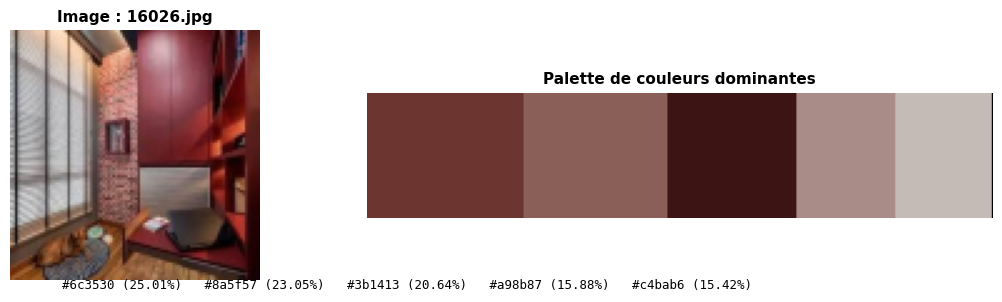

🎨 Palette extraite :
   1. #6c3530  |  RGB(np.int64(108), np.int64(53), np.int64(48))  |  25.01%
   2. #8a5f57  |  RGB(np.int64(138), np.int64(95), np.int64(87))  |  23.05%
   3. #3b1413  |  RGB(np.int64(59), np.int64(20), np.int64(19))  |  20.64%
   4. #a98b87  |  RGB(np.int64(169), np.int64(139), np.int64(135))  |  15.88%
   5. #c4bab6  |  RGB(np.int64(196), np.int64(186), np.int64(182))  |  15.42%

----------------------------------------------------------------------

📌 STYLE : INDUSTRIEL
   Échantillon : 10927.jpg


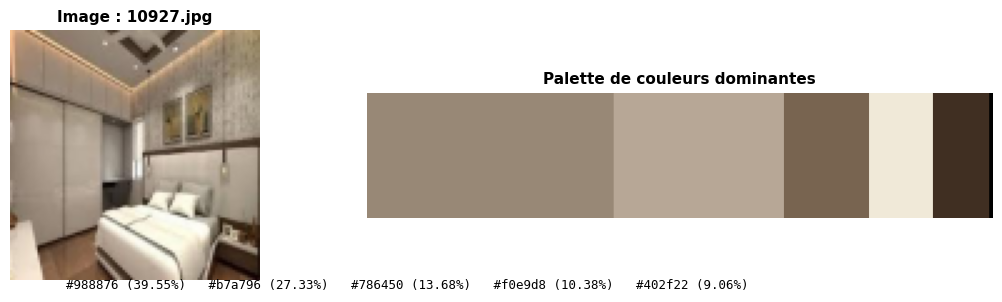

🎨 Palette extraite :
   1. #988876  |  RGB(np.int64(152), np.int64(136), np.int64(118))  |  39.55%
   2. #b7a796  |  RGB(np.int64(183), np.int64(167), np.int64(150))  |  27.33%
   3. #786450  |  RGB(np.int64(120), np.int64(100), np.int64(80))  |  13.68%
   4. #f0e9d8  |  RGB(np.int64(240), np.int64(233), np.int64(216))  |  10.38%
   5. #402f22  |  RGB(np.int64(64), np.int64(47), np.int64(34))  |   9.06%

----------------------------------------------------------------------

📌 STYLE : MINIMALISTE
   Échantillon : 10133.jpg


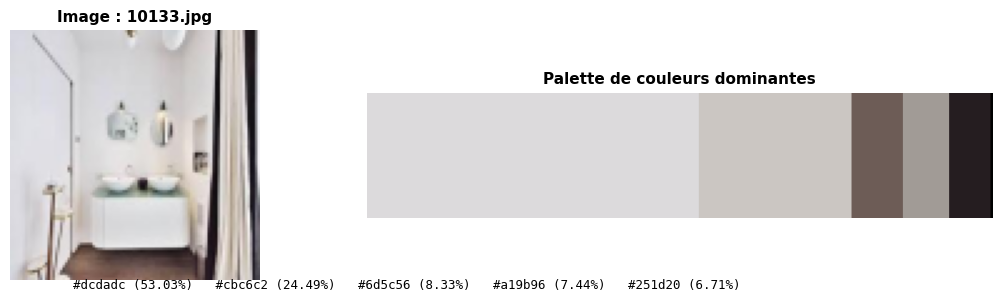

🎨 Palette extraite :
   1. #dcdadc  |  RGB(np.int64(220), np.int64(218), np.int64(220))  |  53.03%
   2. #cbc6c2  |  RGB(np.int64(203), np.int64(198), np.int64(194))  |  24.49%
   3. #6d5c56  |  RGB(np.int64(109), np.int64(92), np.int64(86))  |   8.33%
   4. #a19b96  |  RGB(np.int64(161), np.int64(155), np.int64(150))  |   7.44%
   5. #251d20  |  RGB(np.int64(37), np.int64(29), np.int64(32))  |   6.71%

----------------------------------------------------------------------

📌 STYLE : MODERNE
   Échantillon : 10927.jpg


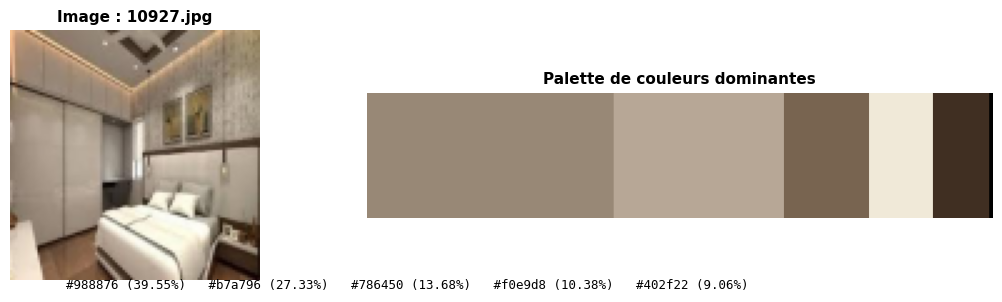

🎨 Palette extraite :
   1. #988876  |  RGB(np.int64(152), np.int64(136), np.int64(118))  |  39.55%
   2. #b7a796  |  RGB(np.int64(183), np.int64(167), np.int64(150))  |  27.33%
   3. #786450  |  RGB(np.int64(120), np.int64(100), np.int64(80))  |  13.68%
   4. #f0e9d8  |  RGB(np.int64(240), np.int64(233), np.int64(216))  |  10.38%
   5. #402f22  |  RGB(np.int64(64), np.int64(47), np.int64(34))  |   9.06%

----------------------------------------------------------------------

📌 STYLE : ROYAL
   Échantillon : 1000.jpg


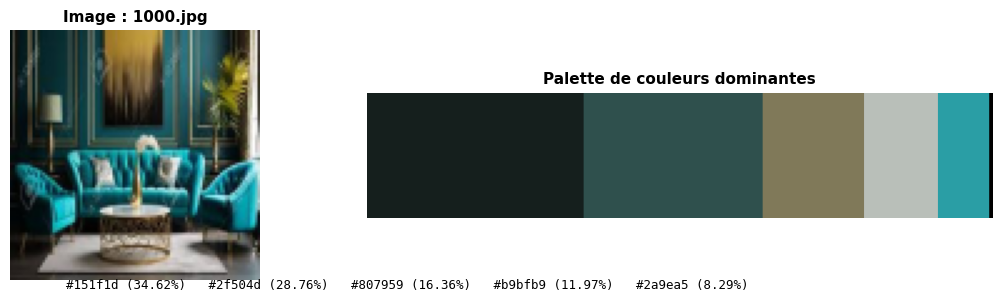

🎨 Palette extraite :
   1. #151f1d  |  RGB(np.int64(21), np.int64(31), np.int64(29))  |  34.62%
   2. #2f504d  |  RGB(np.int64(47), np.int64(80), np.int64(77))  |  28.76%
   3. #807959  |  RGB(np.int64(128), np.int64(121), np.int64(89))  |  16.36%
   4. #b9bfb9  |  RGB(np.int64(185), np.int64(191), np.int64(185))  |  11.97%
   5. #2a9ea5  |  RGB(np.int64(42), np.int64(158), np.int64(165))  |   8.29%

----------------------------------------------------------------------

📌 STYLE : RUSTIQUE
   Échantillon : 20037.jpg


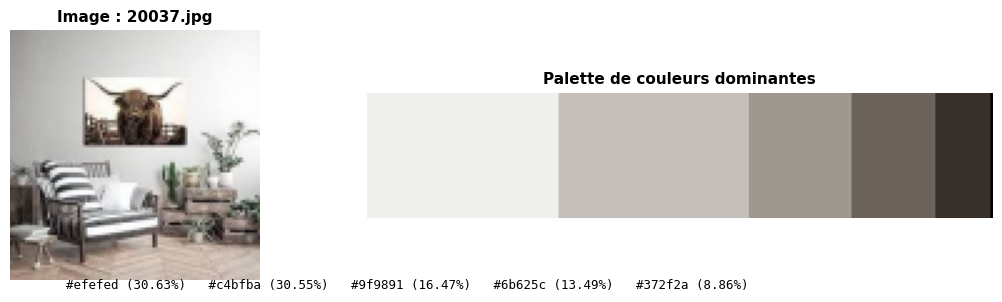

🎨 Palette extraite :
   1. #efefed  |  RGB(np.int64(239), np.int64(239), np.int64(237))  |  30.63%
   2. #c4bfba  |  RGB(np.int64(196), np.int64(191), np.int64(186))  |  30.55%
   3. #9f9891  |  RGB(np.int64(159), np.int64(152), np.int64(145))  |  16.47%
   4. #6b625c  |  RGB(np.int64(107), np.int64(98), np.int64(92))  |  13.49%
   5. #372f2a  |  RGB(np.int64(55), np.int64(47), np.int64(42))  |   8.86%

----------------------------------------------------------------------

📌 STYLE : VINTAGE
   Échantillon : 23989.jpg


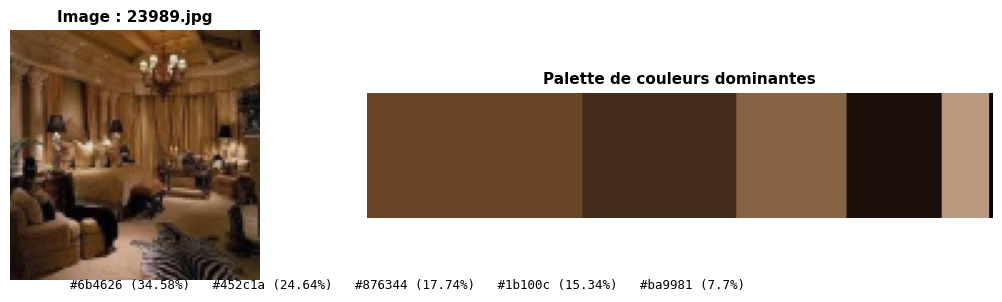

🎨 Palette extraite :
   1. #6b4626  |  RGB(np.int64(107), np.int64(70), np.int64(38))  |  34.58%
   2. #452c1a  |  RGB(np.int64(69), np.int64(44), np.int64(26))  |  24.64%
   3. #876344  |  RGB(np.int64(135), np.int64(99), np.int64(68))  |  17.74%
   4. #1b100c  |  RGB(np.int64(27), np.int64(16), np.int64(12))  |  15.34%
   5. #ba9981  |  RGB(np.int64(186), np.int64(153), np.int64(129))  |   7.70%

----------------------------------------------------------------------

✅ 7 styles analysés sur 7 disponibles


In [39]:
def compare_all_styles():
    """Compare un échantillon de chaque style disponible"""
    
    if not DATASET_READY:
        print("⚠️  Dataset non configuré")
        return
    
    print("=" * 70)
    print("🌈 COMPARAISON DES STYLES DU DATASET")
    print("=" * 70)
    print()
    
    styles_analyzed = 0
    
    for style in STYLES:
        if WORKING_INFO[style]['count'] == 0:
            print(f"\n⚠️  {style.upper()} : Aucune image disponible")
            continue
        
        # Prendre la première image du style
        test_image = WORKING_INFO[style]['images'][0]
        
        print(f"\n📌 STYLE : {style.upper()}")
        print(f"   Échantillon : {Path(test_image).name}")
        
        result =extract_dominant_colors_fast(test_image)
        
        if result['success']:
            visualize_extraction(result, figsize=(12, 3))
            styles_analyzed += 1
        else:
            print(f"   ❌ {result['error']}")
        
        print("-" * 70)
    
    print(f"\n✅ {styles_analyzed} styles analysés sur {len(STYLES)} disponibles")


# Comparer tous les styles
if DATASET_READY:
    compare_all_styles()


Étape 9 : Benchmark de performance

In [40]:
def benchmark_extraction(num_tests: int = 10):
    """
    Mesure les performances d'extraction de couleurs
    
    Args:
        num_tests: Nombre de tests à effectuer
    """
    if not DATASET_READY:
        print("⚠️  Dataset non configuré")
        return
    
    # Collecter des images de test
    test_images = []
    for style in STYLES:
        if WORKING_INFO[style]['count'] > 0:
            test_images.extend(WORKING_INFO[style]['images'][:2])
        if len(test_images) >= num_tests:
            break
    
    if not test_images:
        print("❌ Aucune image disponible pour le benchmark")
        return
    
    test_images = test_images[:num_tests]
    
    print("⚡ BENCHMARK DE PERFORMANCE")
    print("=" * 70)
    print(f"Nombre de tests : {len(test_images)}")
    print(f"Dimension de redimensionnement : 150x150 pixels")
    print()
    
    times = []
    
    for i, test_img in enumerate(test_images, 1):
        start = time.time()
        result = extract_dominant_colors_fast(test_img)
        end = time.time()
        
        if result['success']:
            elapsed = (end - start) * 1000  # en millisecondes
            times.append(elapsed)
            print(f"   Test {i:2d}/{len(test_images)} : {elapsed:6.2f} ms")
    
    if times:
        print()
        print("📊 Statistiques :")
        print(f"   • Temps moyen    : {np.mean(times):6.2f} ms")
        print(f"   • Temps minimum  : {np.min(times):6.2f} ms")
        print(f"   • Temps maximum  : {np.max(times):6.2f} ms")
        print(f"   • Écart-type     : {np.std(times):6.2f} ms")
        print()
        
        avg_time = np.mean(times)
        if avg_time <= 100:
            print("✅ Objectif atteint : ≤100ms par image")
        else:
            print(f"⚠️  Temps supérieur à l'objectif de 100ms")
            print(f"   Optimisation possible : réduire resize_dim")
    
    print("=" * 70)


# Lancer le benchmark
if DATASET_READY:
    benchmark_extraction(num_tests=10)


⚡ BENCHMARK DE PERFORMANCE
Nombre de tests : 10
Dimension de redimensionnement : 150x150 pixels

   Test  1/10 :  30.99 ms
   Test  2/10 :  32.00 ms
   Test  3/10 :  27.00 ms
   Test  4/10 :  31.00 ms
   Test  5/10 :  27.00 ms
   Test  6/10 :  35.00 ms
   Test  7/10 :  29.13 ms
   Test  8/10 :  31.00 ms
   Test  9/10 :  36.00 ms
   Test 10/10 :  27.00 ms

📊 Statistiques :
   • Temps moyen    :  30.61 ms
   • Temps minimum  :  27.00 ms
   • Temps maximum  :  36.00 ms
   • Écart-type     :   3.03 ms

✅ Objectif atteint : ≤100ms par image


In [41]:
def save_palette_results(style_name: str, num_images: int = 5):
    """
    Sauvegarde les palettes de couleurs dans un fichier texte
    
    Args:
        style_name: Nom du style à analyser
        num_images: Nombre d'images à traiter
    """
    if not DATASET_READY:
        print("⚠️  Dataset non configuré")
        return
    
    if style_name not in STYLES or WORKING_INFO[style_name]['count'] == 0:
        print(f"❌ Style '{style_name}' non disponible")
        return
    
    # Créer le dossier de résultats
    output_dir = BASE_DIR / "results" / "color_analysis"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Récupérer les images
    images = WORKING_INFO[style_name]['images'][:num_images]
    
    print(f"💾 Sauvegarde des palettes pour '{style_name}'...")
    
    # Créer le fichier de résultats
    results_file = output_dir / f"{style_name}_palettes.txt"
    
    with open(results_file, 'w', encoding='utf-8') as f:
        f.write(f"PALETTES DE COULEURS - STYLE : {style_name.upper()}\n")
        f.write("=" * 70 + "\n")
        f.write(f"Date : {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Nombre d'images analysées : {len(images)}\n")
        f.write("=" * 70 + "\n\n")
        
        for i, img_path in enumerate(images, 1):
            result = extract_dominant_colors_fast(img_path)
            
            if result['success']:
                f.write(f"Image {i} : {Path(img_path).name}\n")
                f.write("-" * 70 + "\n")
                
                for j, (color, pct, rgb) in enumerate(zip(
                    result['colors'], result['percentages'], result['rgb_colors']
                ), 1):
                    f.write(f"  {j}. {color}  |  RGB{rgb}  |  {pct:5.2f}%\n")
                
                f.write("\n")
    
    print(f"✅ Résultats sauvegardés : {results_file}")
    print(f"📂 Dossier : {output_dir}")


# Sauvegarder les résultats du premier style disponible
if DATASET_READY:
    for style in STYLES:
        if WORKING_INFO[style]['count'] > 0:
            save_palette_results(style, num_images=5)
            break


💾 Sauvegarde des palettes pour 'boheme'...
✅ Résultats sauvegardés : c:\Users\msi\Downloads\Computer-vision-project\Computer-vision-project\notebooks\..\results\color_analysis\boheme_palettes.txt
📂 Dossier : c:\Users\msi\Downloads\Computer-vision-project\Computer-vision-project\notebooks\..\results\color_analysis
